In [807]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import gc
from datetime import datetime 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
pd.set_option('display.max_columns', 100)

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifie
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split
#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation
RANDOM_STATE = 2268
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50  #Print out metric result
IS_LOCAL = False
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos
data = pd.read_csv("mushroom_cleaned.csv")
data

cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
0              1372          2                2          10     3.807467   
1              1461          2                2          10     3.807467   
2              1371          2                2          10     3.612496   
3              1261          6                2          10     3.787572   
4              1305          6                2          10     3.711971   
...             ...        ...              ...         ...          ...   
54030            73          5                3           2     0.887740   
54031            82          2                3           2     1.186164   
54032            82          5                3           2     0.915593   
54033            79          2                3           2     1.034963   
54034            72          5                3           2     1.158311   

       stem-width  stem-color    season  class  
0            1545          11  1.804273      1  
1            1557          11  1.804273      1  
2            1566          11  1.804273      1  
3            1566          11  1.804273      1  
4            1464          11  0.943195      1  
...           ...         ...       ...    ...  
54030         569          12  0.943195      1  
54031         490          12  0.943195      1  
54032         584          12  0.888450      1  
54033         491          12  0.888450      1  
54034         492          12  0.888450      1  

[54035 rows x 9 columns]

In [808]:
data.head()

cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
0          1372          2                2          10     3.807467   
1          1461          2                2          10     3.807467   
2          1371          2                2          10     3.612496   
3          1261          6                2          10     3.787572   
4          1305          6                2          10     3.711971   

   stem-width  stem-color    season  class  
0        1545          11  1.804273      1  
1        1557          11  1.804273      1  
2        1566          11  1.804273      1  
3        1566          11  1.804273      1  
4        1464          11  0.943195      1

In [809]:
data.sample(10)

cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
40751            52          4                0           3     1.146375   
18226           437          6                0          11     0.003553   
25180          1052          5                6           5     0.652128   
5488            681          5                1          10     0.163564   
30857           268          2                5           7     0.788266   
52885           200          3                3           2     1.229933   
8392            341          0                6          10     0.696749   
11581            75          6                0          10     0.354556   
38823          1150          2                2           5     0.970448   
33726           533          6                6           5     0.974427   

       stem-width  stem-color    season  class  
40751         106          11  0.943195      0  
18226         782           7  0.943195      1  
25180        2519           8  0.943195      0  
5488          745          11  0.943195      0  
30857         239           6  0.943195      1  
52885        1330           3  0.943195      1  
8392          222          12  0.943195      0  
11581         108          12  0.943195      0  
38823        1773          11  0.888450      0  
33726        1029           6  0.888450      0

In [810]:
data.shape

(54035, 9)

In [811]:
data.corr()

cap-diameter  cap-shape  gill-attachment  gill-color  \
cap-diameter         1.000000   0.204011         0.200481    0.186377   
cap-shape            0.204011   1.000000         0.043066    0.131387   
gill-attachment      0.200481   0.043066         1.000000    0.100276   
gill-color           0.186377   0.131387         0.100276    1.000000   
stem-height          0.135652  -0.010393        -0.075284    0.015057   
stem-width           0.828469   0.222494         0.245300    0.110283   
stem-color           0.121856   0.029035         0.020073    0.186090   
season               0.113334   0.055442        -0.040315    0.059965   
class               -0.165676  -0.133338        -0.052541   -0.063947   

                 stem-height  stem-width  stem-color    season     class  
cap-diameter        0.135652    0.828469    0.121856  0.113334 -0.165676  
cap-shape          -0.010393    0.222494    0.029035  0.055442 -0.133338  
gill-attachment    -0.075284    0.245300    0.020073 -0.040315 -0.052541  
gill-color          0.015057    0.110283    0.186090  0.059965 -0.063947  
stem-height         1.000000    0.098095    0.002624 -0.000292  0.183354  
stem-width          0.098095    1.000000    0.157394  0.040679 -0.182856  
stem-color          0.002624    0.157394    1.000000  0.010750 -0.128339  
season             -0.000292    0.040679    0.010750  1.000000 -0.082919  
class               0.183354   -0.182856   -0.128339 -0.082919  1.000000

In [812]:
data.describe()

cap-diameter     cap-shape  gill-attachment    gill-color  \
count  54035.000000  54035.000000     54035.000000  54035.000000   
mean     567.257204      4.000315         2.142056      7.329509   
std      359.883763      2.160505         2.228821      3.200266   
min        0.000000      0.000000         0.000000      0.000000   
25%      289.000000      2.000000         0.000000      5.000000   
50%      525.000000      5.000000         1.000000      8.000000   
75%      781.000000      6.000000         4.000000     10.000000   
max     1891.000000      6.000000         6.000000     11.000000   

        stem-height    stem-width    stem-color        season         class  
count  54035.000000  54035.000000  54035.000000  54035.000000  54035.000000  
mean       0.759110   1051.081299      8.418062      0.952163      0.549181  
std        0.650969    782.056076      3.262078      0.305594      0.497580  
min        0.000426      0.000000      0.000000      0.027372      0.000000  
25%        0.270997    421.000000      6.000000      0.888450      0.000000  
50%        0.593295    923.000000     11.000000      0.943195      1.000000  
75%        1.054858   1523.000000     11.000000      0.943195      1.000000  
max        3.835320   3569.000000     12.000000      1.804273      1.000000

In [813]:
data.isnull()

cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
0             False      False            False       False        False   
1             False      False            False       False        False   
2             False      False            False       False        False   
3             False      False            False       False        False   
4             False      False            False       False        False   
...             ...        ...              ...         ...          ...   
54030         False      False            False       False        False   
54031         False      False            False       False        False   
54032         False      False            False       False        False   
54033         False      False            False       False        False   
54034         False      False            False       False        False   

       stem-width  stem-color  season  class  
0           False       False   False  False  
1           False       False   False  False  
2           False       False   False  False  
3           False       False   False  False  
4           False       False   False  False  
...           ...         ...     ...    ...  
54030       False       False   False  False  
54031       False       False   False  False  
54032       False       False   False  False  
54033       False       False   False  False  
54034       False       False   False  False  

[54035 rows x 9 columns]

In [814]:
data.isnull().sum()

cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64

In [815]:
data.dtypes.value_counts()


int64      7
float64    2
Name: count, dtype: int64

In [816]:
data['class'].value_counts()


class
1    29675
0    24360
Name: count, dtype: int64

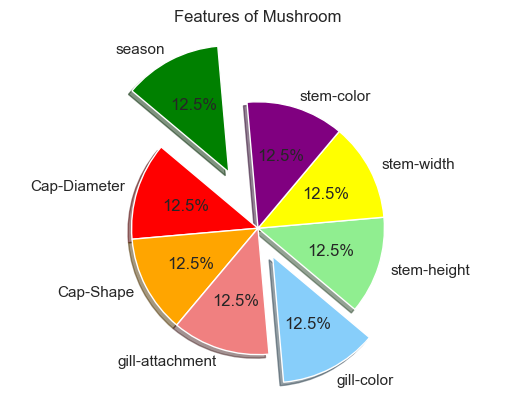

In [817]:
import matplotlib.pyplot as plt
labels = ['Cap-Diameter', 'Cap-Shape', 'gill-attachment', 'gill-color', 'stem-height','stem-width' ,'stem-color' ,'season']
sizes = [10, 10, 10, 10, 10, 10, 10, 10] 
colors = ['red', 'orange', 'lightcoral', 'lightskyblue', 'lightgreen','yellow','purple','green','brown']
explode = (0, 0, 0, 0.25, 0, 0, 0, 0.5)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Features of Mushroom')
plt.show()

<Axes: xlabel='class'>

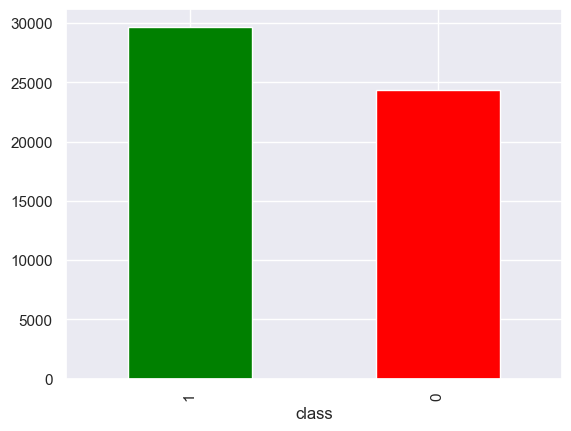

In [818]:
data['class'].value_counts().plot.bar(color=['green', 'red'])

In [819]:
class_0 = data.loc[data['class'] == 0]["cap-shape"]
class_1 = data.loc[data['class'] == 1]["cap-shape"]

hist_data = [class_0, class_1]
group_labels = ['Edible', 'Poison']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig.update_layout(title='Mushroom Cap Shape Density Plot', xaxis=dict(title='Cap Shape'))
iplot(fig, filename='dist_only')


In [820]:
MC = data.groupby(['cap-shape', 'class'])['season'].agg(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(MC)
df.columns = ['cap-shape', 'class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

cap-shape  class       Min       Max  Transactions          Sum      Mean  \
0          0      0  0.027372  1.804273          1258  1115.078245  0.886390   
1          0      1  0.027372  1.804273          4015  3564.004516  0.887672   
2          1      0  0.027372  0.943195           774   596.941732  0.771243   
3          1      1  0.027372  0.943195           948   765.358399  0.807340   
4          2      0  0.027372  1.804273          5918  6220.259103  1.051075   

     Median       Var  
0  0.915822  0.216323  
1  0.888450  0.066950  
2  0.888450  0.107342  
3  0.888450  0.085566  
4  0.943195  0.163442

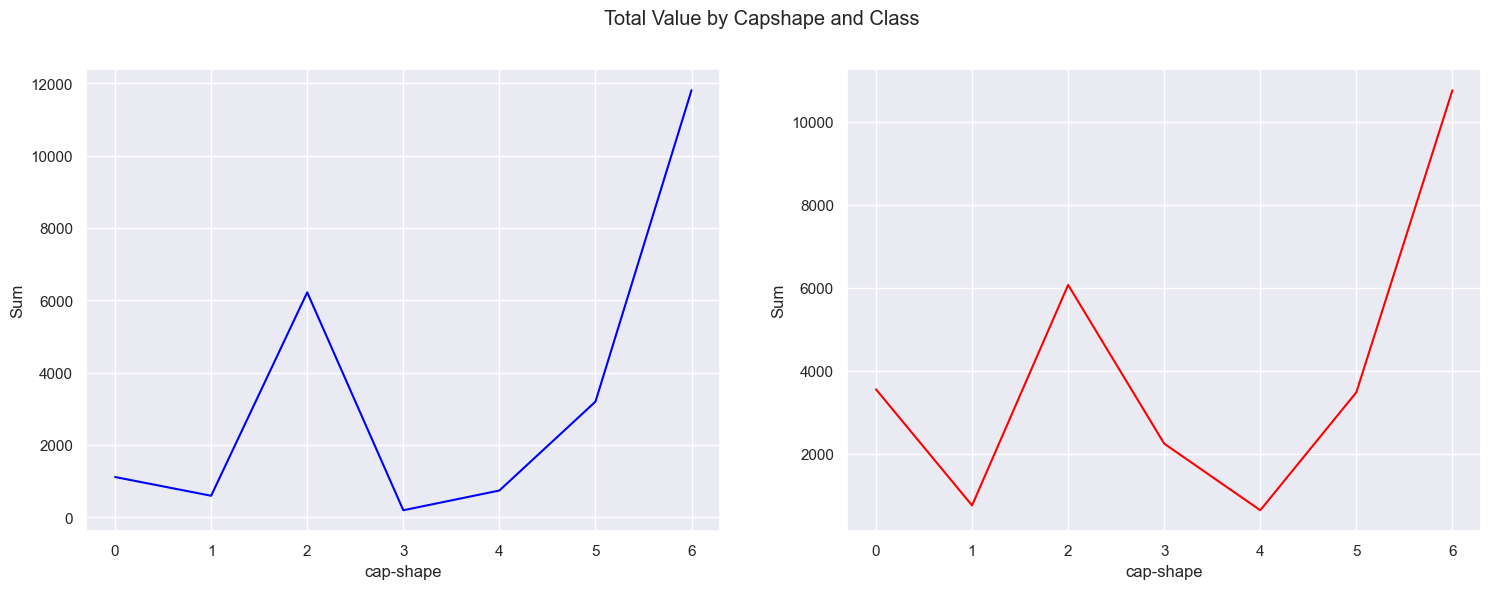

In [821]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.lineplot(x="cap-shape", y="Sum", data=df.loc[df['class'] == 0], ax=ax1, color='blue')
sns.lineplot(x="cap-shape", y="Sum", data=df.loc[df['class'] == 1], ax=ax2, color='red')
plt.suptitle("Total Value by Capshape and Class")
plt.show()

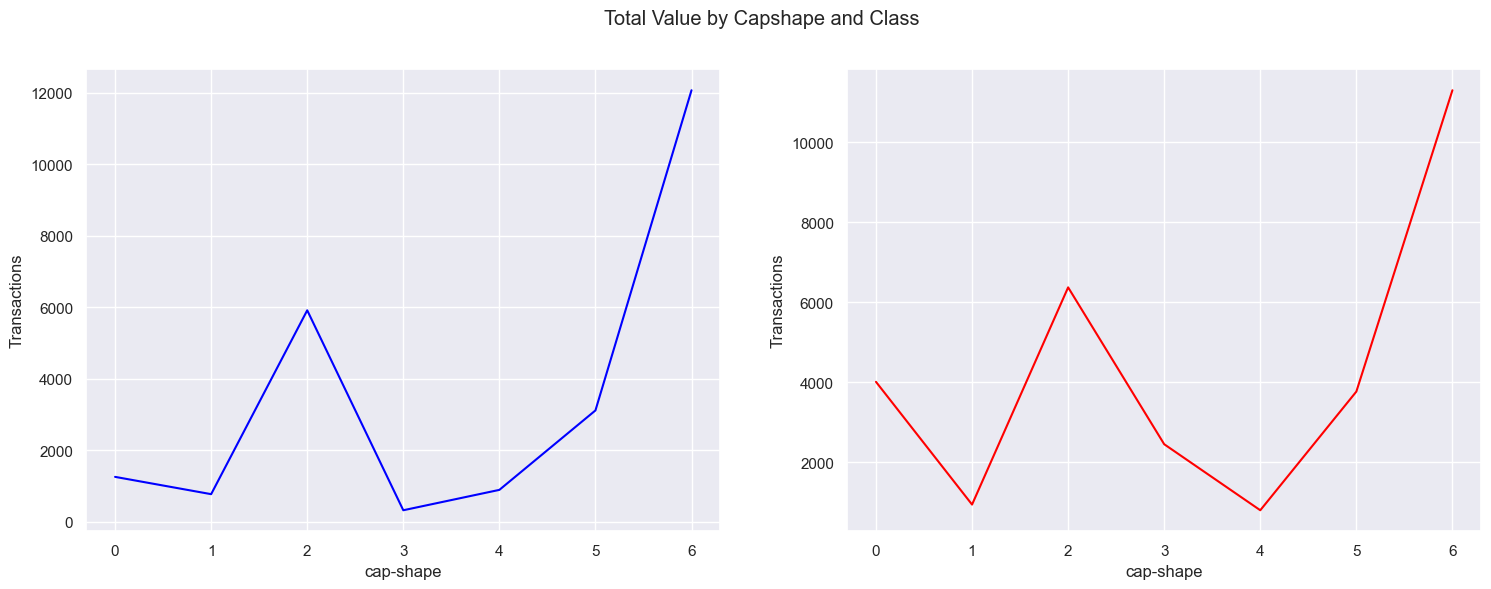

In [822]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.lineplot(x="cap-shape", y="Transactions", data=df.loc[df['class'] == 0], ax=ax1, color='blue')
sns.lineplot(x="cap-shape", y="Transactions", data=df.loc[df['class'] == 1], ax=ax2, color='red')
plt.suptitle("Total Value by Capshape and Class")
plt.show()

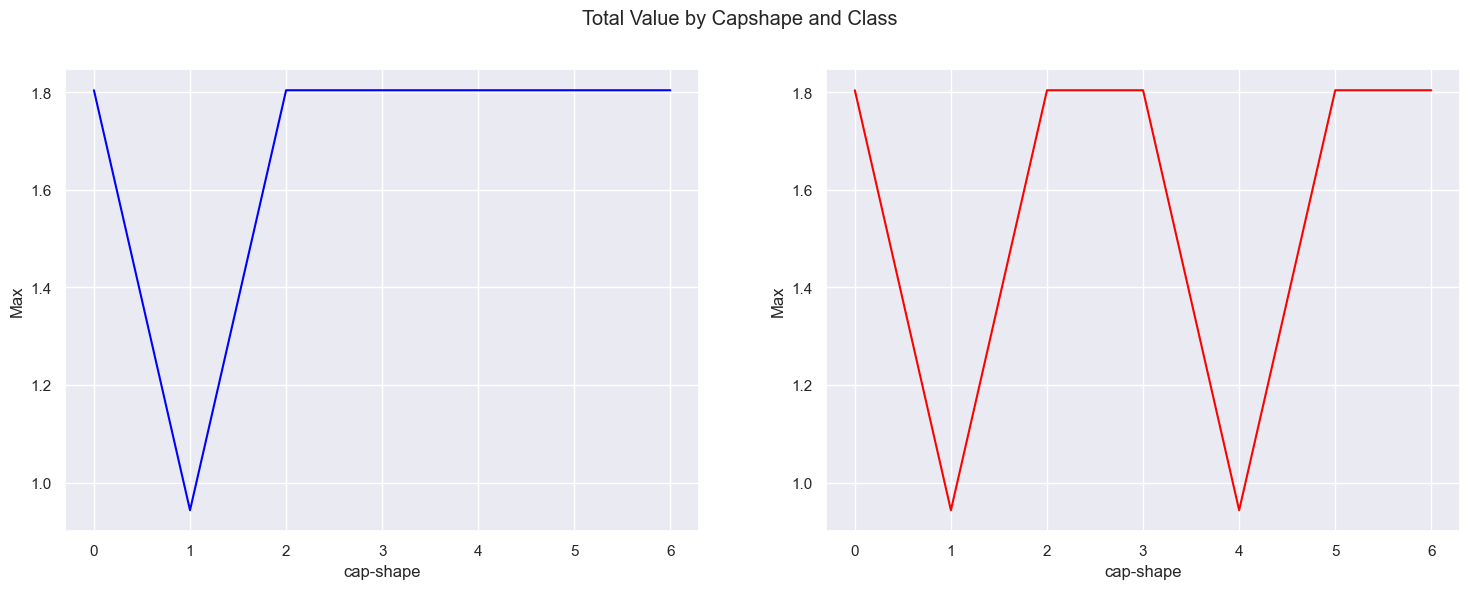

In [823]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.lineplot(x="cap-shape", y="Max", data=df.loc[df['class'] == 0], ax=ax1, color='blue')
sns.lineplot(x="cap-shape", y="Max", data=df.loc[df['class'] == 1], ax=ax2, color='red')
plt.suptitle("Total Value by Capshape and Class")
plt.show()

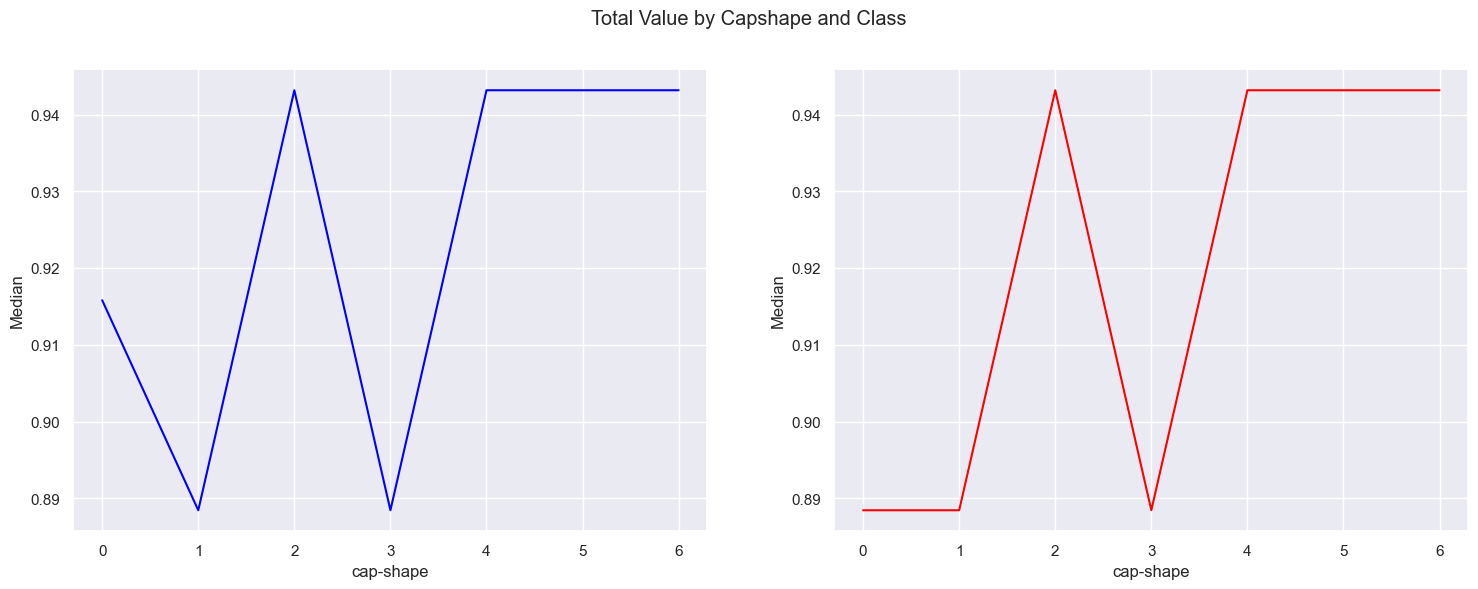

In [824]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.lineplot(x="cap-shape", y="Median", data=df.loc[df['class'] == 0], ax=ax1, color='blue')
sns.lineplot(x="cap-shape", y="Median", data=df.loc[df['class'] == 1], ax=ax2, color='red')
plt.suptitle("Total Value by Capshape and Class")
plt.show()

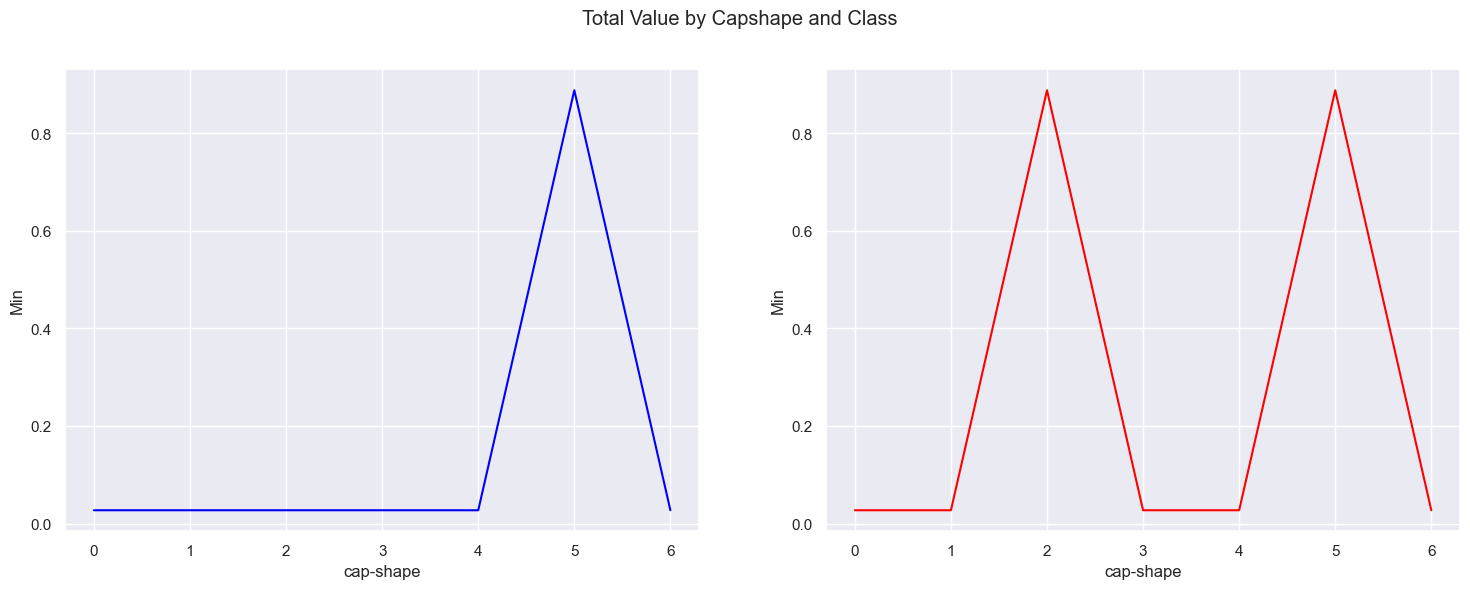

In [825]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.lineplot(x="cap-shape", y="Min", data=df.loc[df['class'] == 0], ax=ax1, color='blue')
sns.lineplot(x="cap-shape", y="Min", data=df.loc[df['class'] == 1], ax=ax2, color='red')
plt.suptitle("Total Value by Capshape and Class")
plt.show()

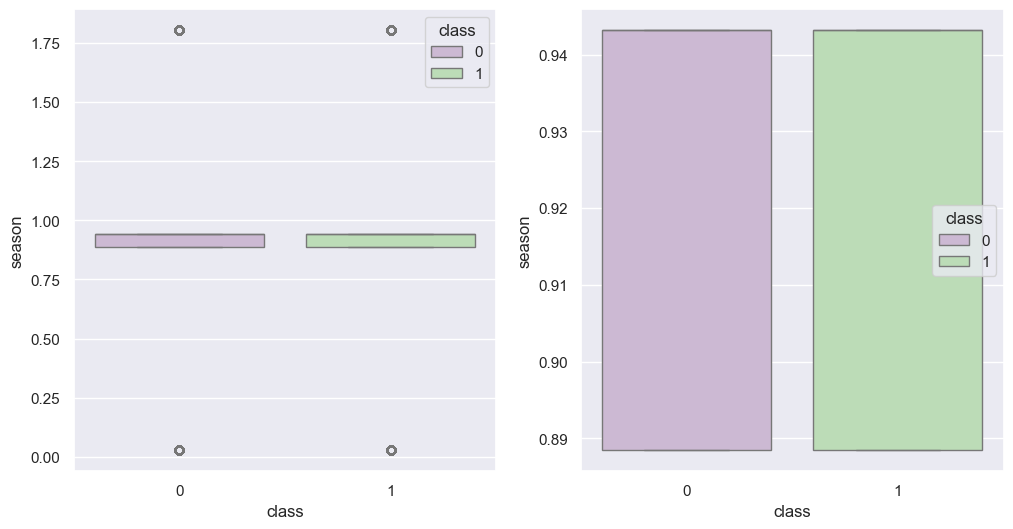

In [826]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="class", y="season", hue="class",data=data, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="class", y="season", hue="class",data=data, palette="PRGn",showfliers=False)
plt.show();

In [827]:
MC = data[['season','class']].copy()
class_0 = MC.loc[MC['class'] == 0]['season']
class_1 = MC.loc[MC['class'] == 1]['season']
class_0.describe()

count    24360.000000
mean         0.980130
std          0.361040
min          0.027372
25%          0.888450
50%          0.943195
75%          0.943195
max          1.804273
Name: season, dtype: float64

In [828]:
class_1.describe()

count    29675.000000
mean         0.929205
std          0.248756
min          0.027372
25%          0.888450
50%          0.943195
75%          0.943195
max          1.804273
Name: season, dtype: float64

In [829]:
fraud = data.loc[data['class'] == 1]
trace = go.Scatter(
    x = fraud['cap-shape'],y = fraud['season'],
    name="season",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['season'],
    mode = "markers"
)
dt = [trace]
layout = dict(title = 'season of fraudulent transactions',
          xaxis = dict(title = 'Cape Shape', showticklabels=True), 
          yaxis = dict(title = 'season'),
          hovermode='closest'
         )
fig = dict(data=dt, layout=layout)
iplot(fig, filename='fraud-amount')

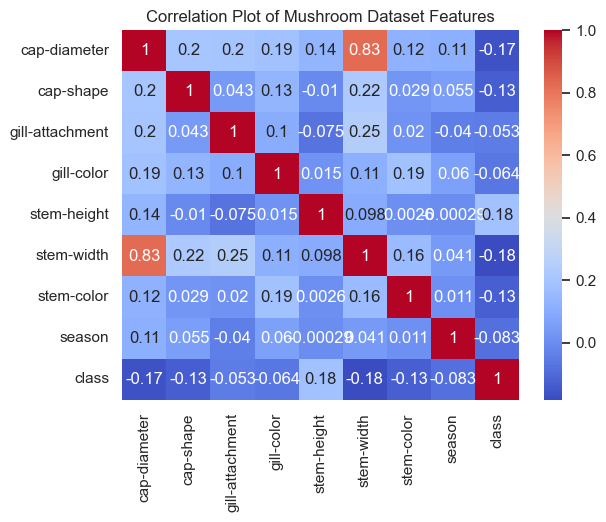

In [830]:
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation Plot of Mushroom Dataset Features')
plt.show()

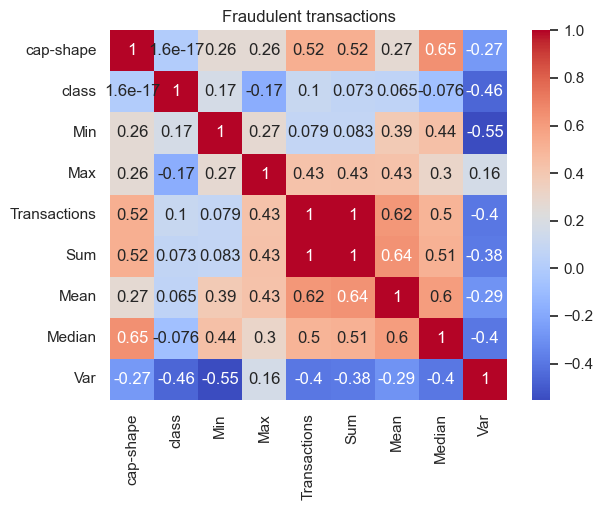

In [831]:
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Fraudulent transactions')
plt.show()

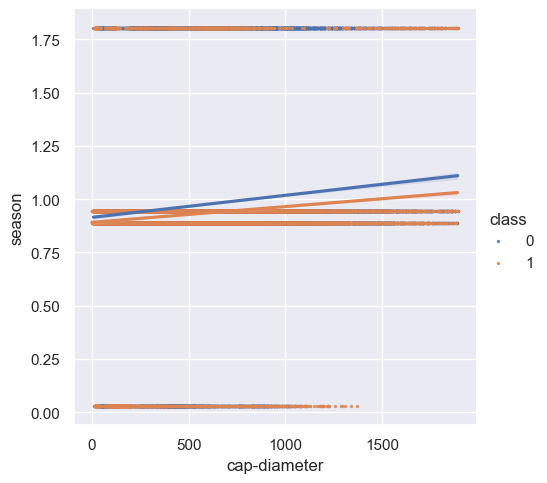

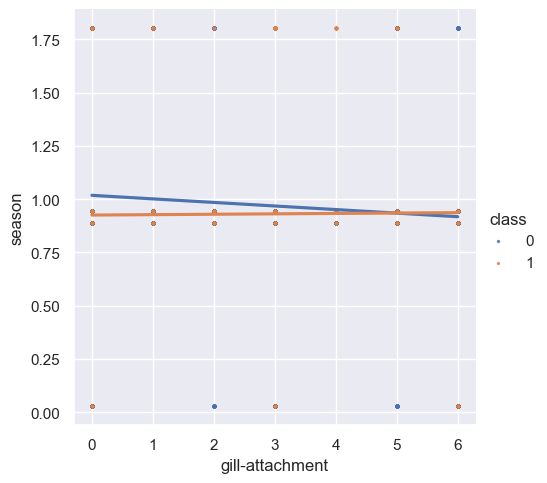

In [832]:
sns.lmplot(x='cap-diameter', y='season',data=data, hue='class', fit_reg=True,scatter_kws={'s':2})
sns.lmplot(x='gill-attachment', y='season',data=data, hue='class', fit_reg=True,scatter_kws={'s':2})
plt.show()

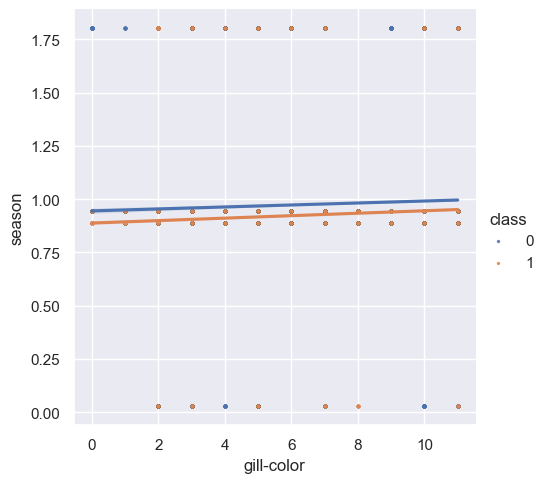

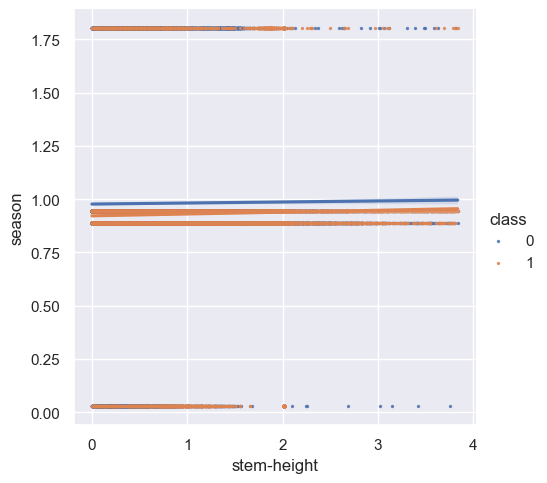

In [833]:
sns.lmplot(x='gill-color', y='season',data=data, hue='class', fit_reg=True,scatter_kws={'s':2})
sns.lmplot(x='stem-height', y='season',data=data, hue='class', fit_reg=True,scatter_kws={'s':2})
plt.show()


<Figure size 640x480 with 0 Axes>

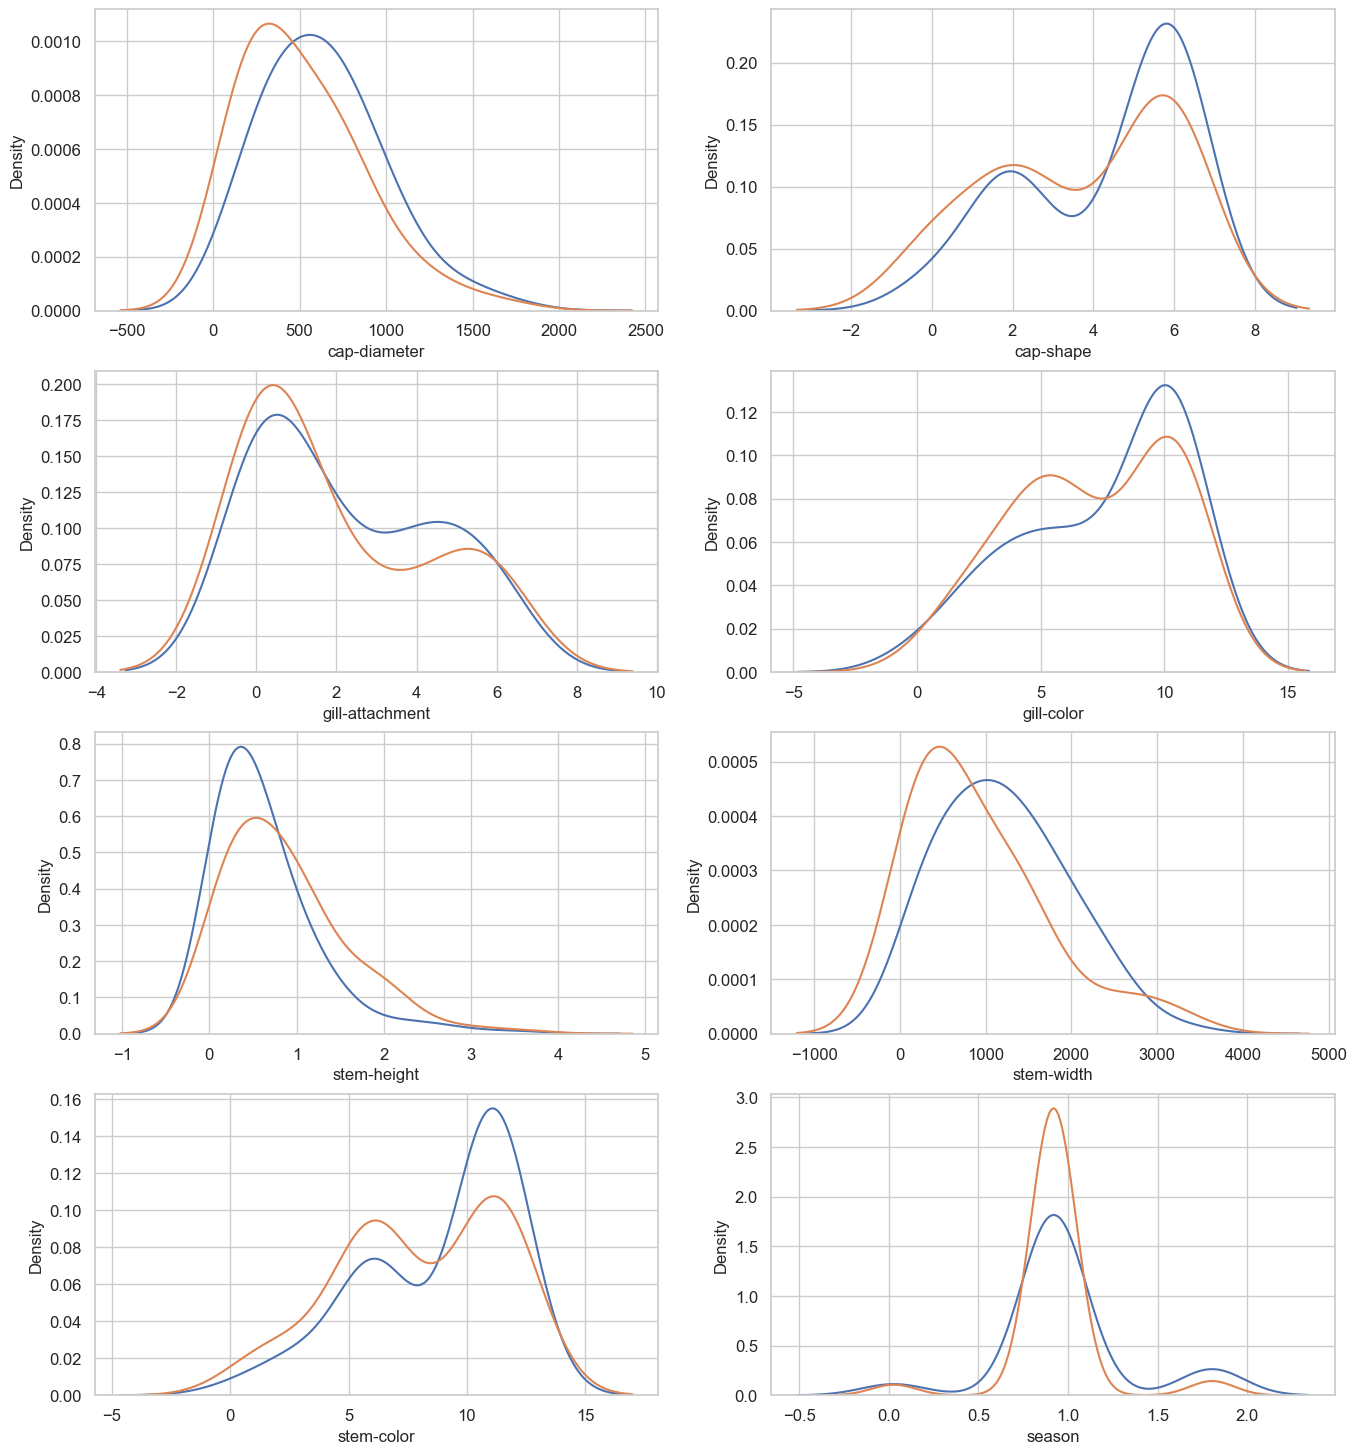

In [834]:
M_C = data.columns.values[:8]
i = 0
t0 = data.loc[data['class'] == 0]
t1 = data.loc[data['class'] == 1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,2,figsize=(16,18))
for feature in M_C:
    i += 1
    plt.subplot(4,2,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

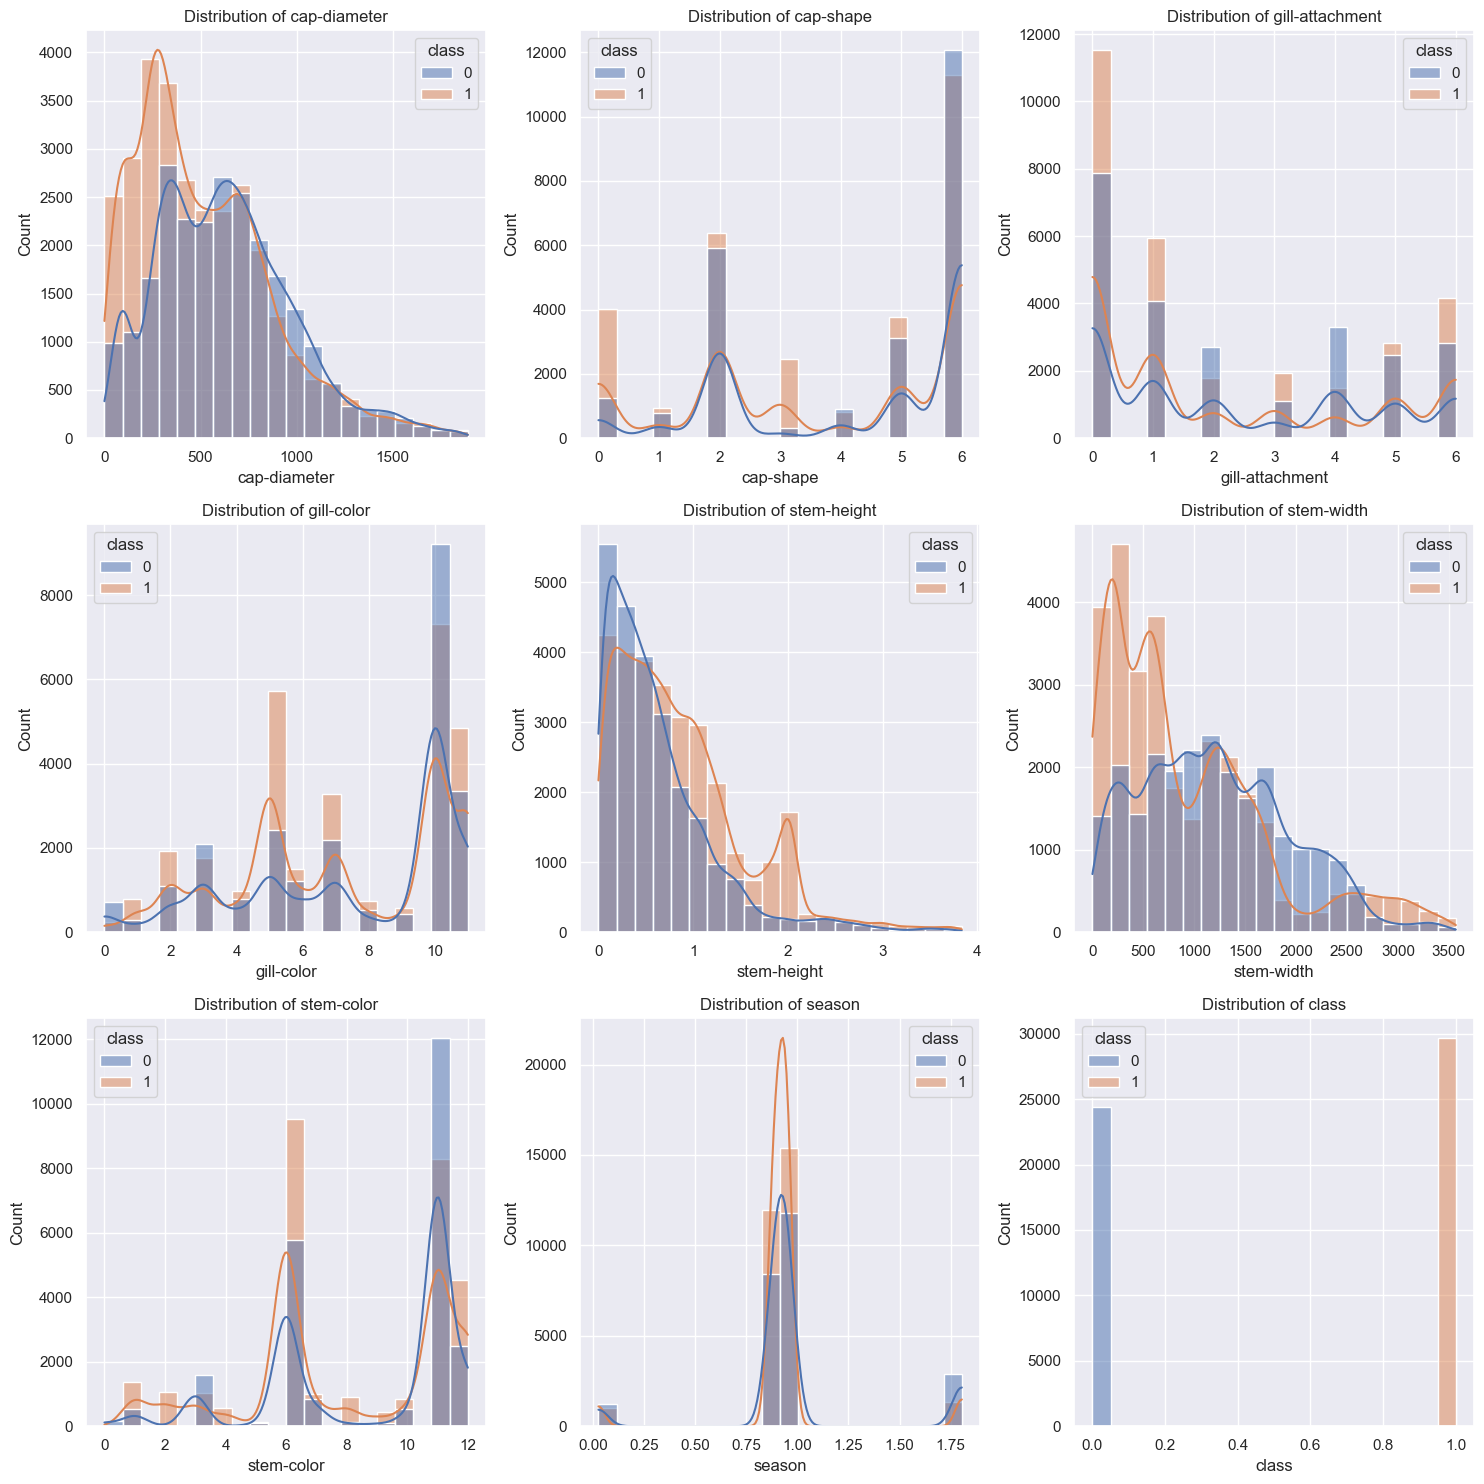

In [835]:
sns.set()
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(data.columns):
 sns.histplot(data=data, x=column, hue='class', kde=True, bins=20, ax=axes[i])
 axes[i].set_title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

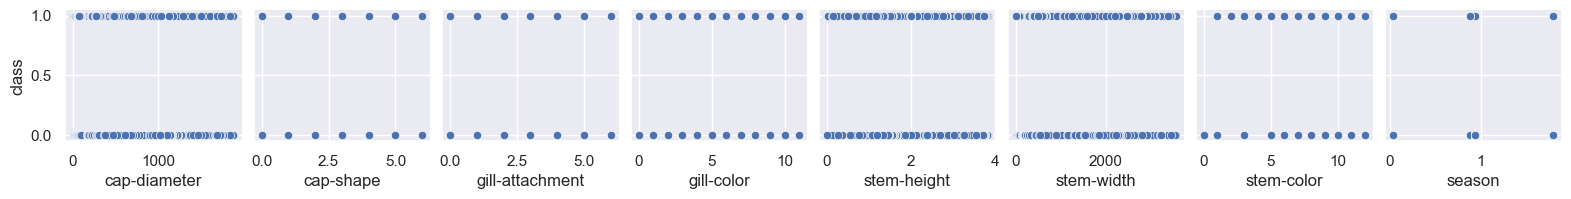

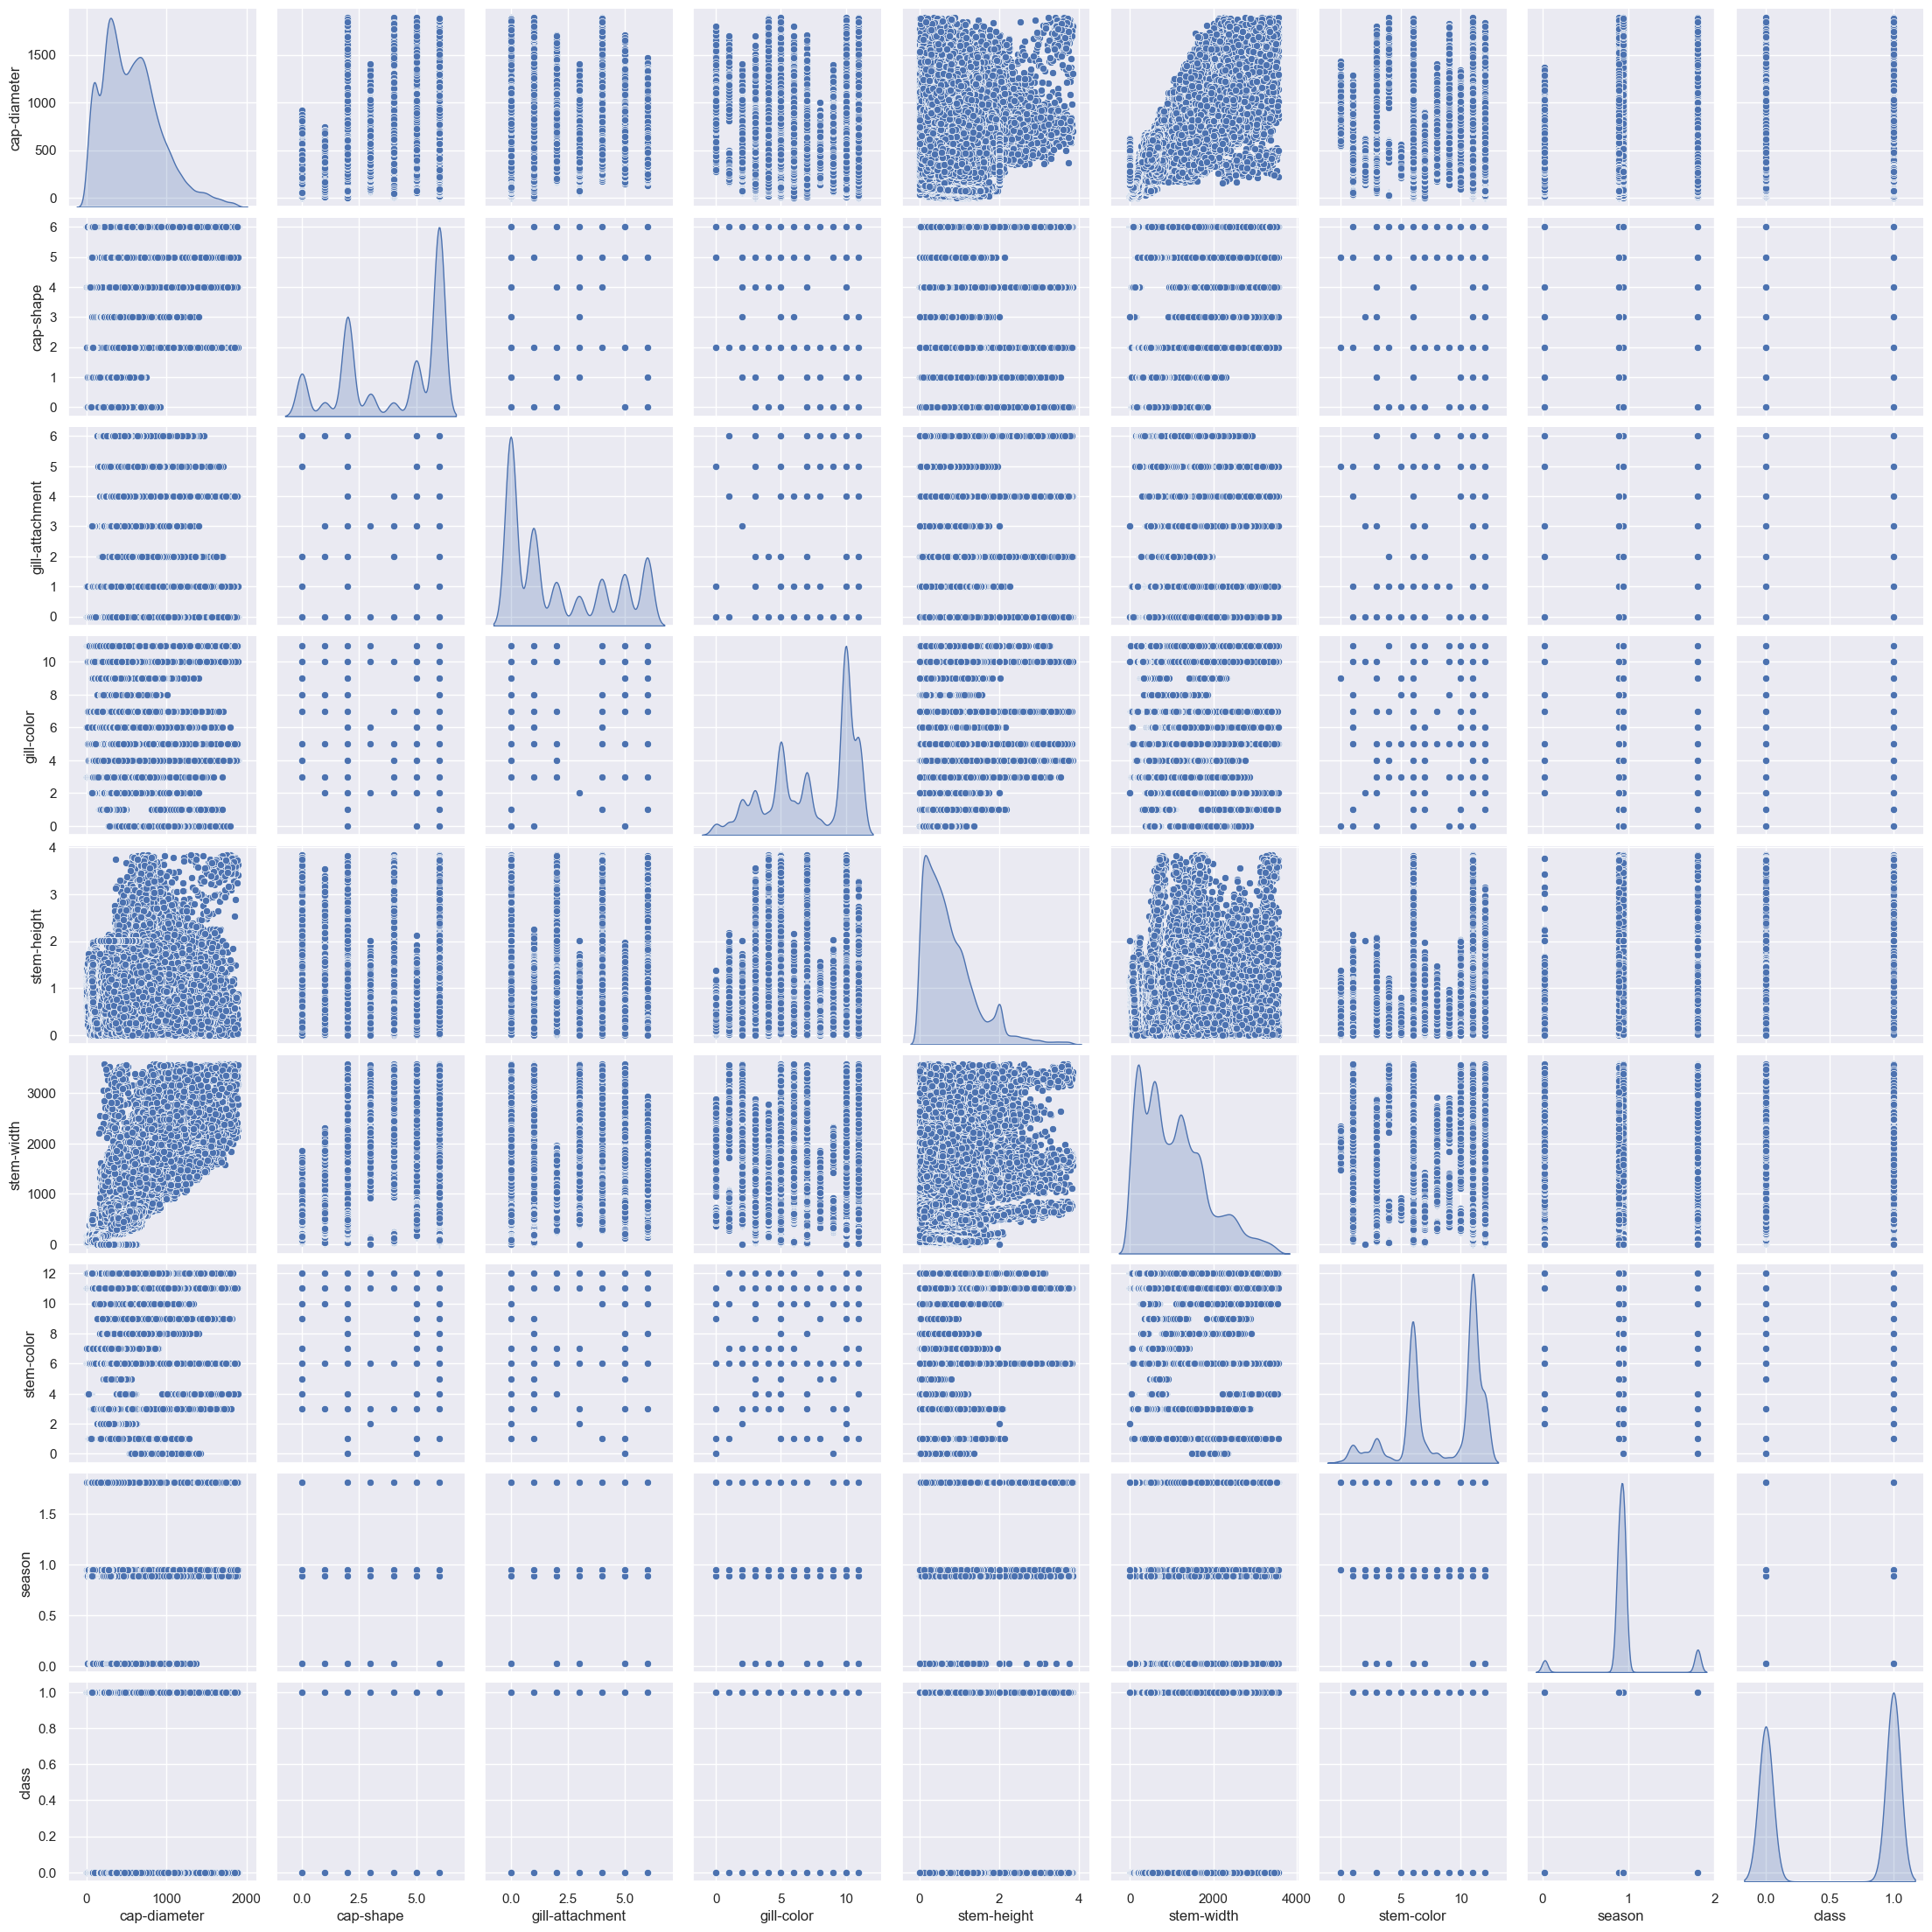

In [836]:
sns.pairplot(data, x_vars=['cap-diameter', 'cap-shape','gill-attachment','gill-color','stem-height','stem-width','stem-color','season'], y_vars='class', height=2, aspect=1, kind='scatter')
plt.show()
sns.pairplot(data=data, diag_kind='kde')

In [837]:
target = 'class'
predictors = ['cap-diameter', 'cap-shape','gill-attachment','gill-color','stem-height','stem-width','stem-color','season']

In [838]:
train_df, test_df = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# (1) XGBoost

In [839]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [840]:
model = xgb.train(params, 
dtrain, 
MAX_ROUNDS, 
watchlist, 
early_stopping_rounds=EARLY_STOP, 
maximize=True, 
verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.66941	valid-auc:0.67025
[50]	train-auc:0.77210	valid-auc:0.76987
[100]	train-auc:0.80999	valid-auc:0.80725
[150]	train-auc:0.83797	valid-auc:0.83457
[200]	train-auc:0.85641	valid-auc:0.85278
[250]	train-auc:0.87168	valid-auc:0.86796
[300]	train-auc:0.88454	valid-auc:0.88115
[350]	train-auc:0.89401	valid-auc:0.89077
[400]	train-auc:0.90145	valid-auc:0.89811
[450]	train-auc:0.90786	valid-auc:0.90427
[500]	train-auc:0.91366	valid-auc:0.90970
[550]	train-auc:0.91879	valid-auc:0.91492
[600]	train-auc:0.92237	valid-auc:0.91846
[650]	train-auc:0.92574	valid-auc:0.92173
[700]	train-auc:0.92874	valid-auc:0.92470
[750]	train-auc:0.93201	valid-auc:0.92791
[800]	train-auc:0.93487	valid-auc:0.93080
[850]	train-auc:0.93801	valid-auc:0.93393
[900]	train-auc:0.94105	valid-auc:0.93692
[950]	train-auc:0.94269	valid-auc:0.93848
[999]	train-auc:0.94483	valid-auc:0.94068


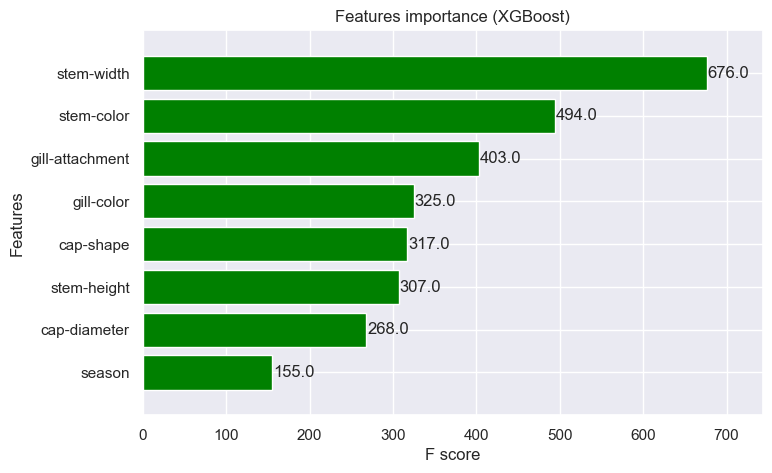

In [841]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [842]:
preds = model.predict(dtest)

In [843]:
roc_auc_test = roc_auc_score(test_df[target].values, preds)
roc_auc_test_percentage = roc_auc_test * 100
print(f"ROC AUC Score (Test Data): {roc_auc_test_percentage:.14f}%")

ROC AUC Score (Test Data): 94.38698811164893%


# Check The Overfitting Gap

[0]	train-merror:0.25333	eval-merror:0.25049
[50]	train-merror:0.01423	eval-merror:0.01666
[100]	train-merror:0.00627	eval-merror:0.01027
[150]	train-merror:0.00331	eval-merror:0.00953
[200]	train-merror:0.00160	eval-merror:0.00916
[226]	train-merror:0.00076	eval-merror:0.00888
Training set score:0.9992
Test set score:0.9911
Overfitting Gap:0.0081


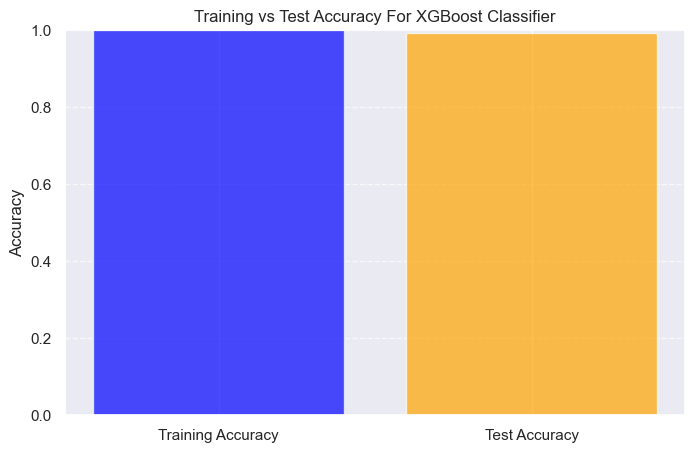

In [844]:
X=data[['cap-diameter','cap-shape','gill-attachment','gill-color','stem-height','stem-width','stem-color','season']]
y=data['class']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
dtrain,dtest=xgb.DMatrix(X_train,label=y_train),xgb.DMatrix(X_test,label=y_test)
params={'objective':'multi:softmax','num_class':3,'eval_metric':'merror'}
model=xgb.train(params,dtrain,1000,[(dtrain,'train'),(dtest,'eval')],early_stopping_rounds=50,verbose_eval=50)
train_preds=model.predict(dtrain)
test_preds=model.predict(dtest)
train_accuracy=accuracy_score(y_train,train_preds)
test_accuracy=accuracy_score(y_test,test_preds)
print('Training set score:{:.4f}'.format(train_accuracy))
print('Test set score:{:.4f}'.format(test_accuracy))
print(f"Overfitting Gap:{train_accuracy-test_accuracy:.4f}")
accuracies=[train_accuracy,test_accuracy]
labels=["Training Accuracy","Test Accuracy"]
plt.figure(figsize=(8,5))
plt.bar(labels,accuracies,color=['blue','orange'],alpha=0.7)
plt.ylim(0,1)
plt.title("Training vs Test Accuracy For XGBoost Classifier")
plt.ylabel("Accuracy")
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.show()


# (2) LightGBM ((Light Gradient Boosting Machine) Model

In [845]:
X = data[['cap-diameter', 'cap-shape','gill-attachment','gill-color','stem-height','stem-width','stem-color','season']]
y = data['class']

In [846]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [847]:
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 20769, number of negative: 17055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 37824, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549096 -> initscore=0.197018
[LightGBM] [Info] Start training from score 0.197018


LGBMClassifier()

In [848]:
y_pred=clf.predict(X_test)

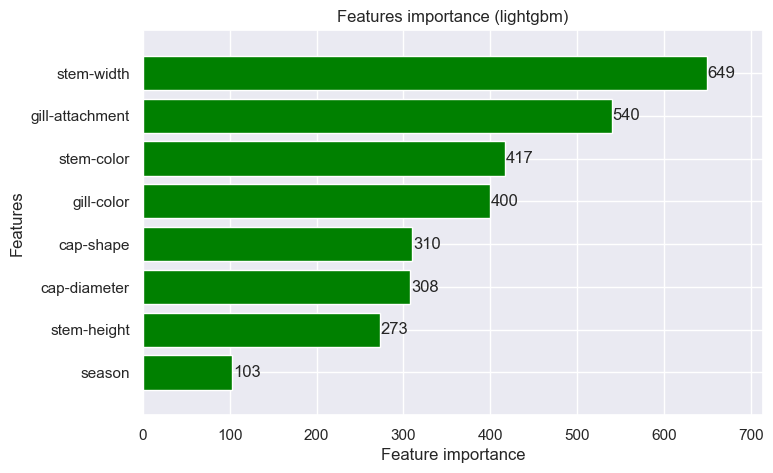

In [849]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (lightgbm)", ax=ax, color="green") 
plt.show()

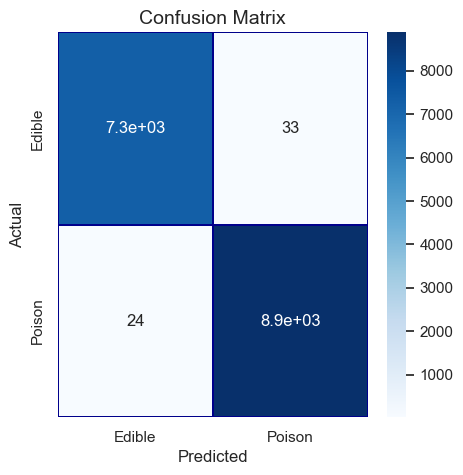

In [850]:
cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, ax1 = plt.subplots(ncols=1, figsize=(5, 5))
sns.heatmap(cm, 
            xticklabels=['Edible', 'Poison'], 
            yticklabels=['Edible', 'Poison'], 
            annot=True, ax=ax1, 
            linewidths=0.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)  
plt.show()

In [851]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(y_test, y_pred))
train_auc = accuracy_score(y_test, y_pred)  
train_auc_percentage = train_auc * 100
print('Full AUC score %.12f%%' % train_auc_percentage)

[[7272   33]
 [  24 8882]]
Full AUC score 99.648386897785%


# Check The Overfitting Gap

[LightGBM] [Info] Number of positive: 20769, number of negative: 17055
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 37824, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549096 -> initscore=0.197018
[LightGBM] [Info] Start training from score 0.197018
Training set score: 0.9815
Test set score: 0.9793
Overfitting Gap: 0.0081


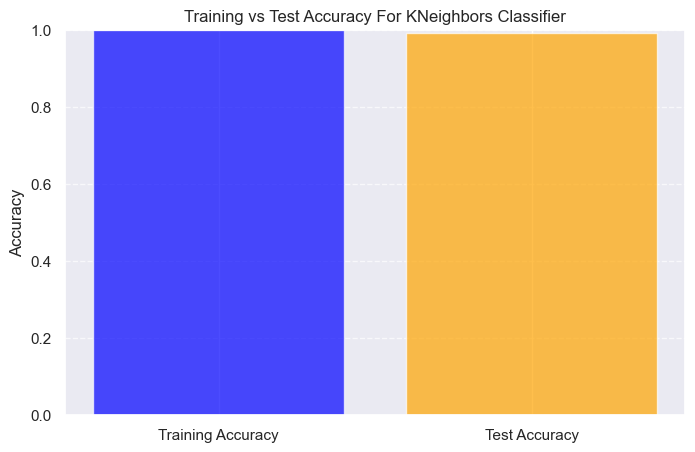

In [852]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
print('Training set score: {:.4f}'.format(model.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(model.score(X_test, y_test)))
print(f"Overfitting Gap: {train_accuracy - test_accuracy:.4f}")
accuracies = [train_accuracy, test_accuracy]
labels = ["Training Accuracy", "Test Accuracy"]
plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'orange'], alpha=0.7)
plt.ylim(0, 1)
plt.title("Training vs Test Accuracy For KNeighbors Classifier")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()